# Getting Started with OpenRarity

This notebook and others are meant to walk through usage of the library and help explain some of the metrics the OpenRarity performs.

Lets consider the fake collection below... 

The data is already formatted as OpenRarity expects it. A dictionary with token_id values for the keys which are mapped to another dictionary containing an `attributes` key and a list of attributes. For different token types other values will be expected but, let's just work with a non-fungible token collection for now.

In [2]:
tokens = {
    1: {
        "attributes": [
            {"trait_type": "hat", "value": "baseball", "display_type": "string"},
            {"name": "shirt", "value": "blue", "display_type": "string"},
            {"name": "shirt", "value": "jacket", "display_type": "string"},
            {"name": "pants", "value": "cargo shorts", "display_type": "string"},
        ]
    },
    2: {
        "attributes": [
            {"name": "hat", "value": "cowboy", "display_type": "string"},
            {"name": "shirt", "value": "tan", "display_type": "string"},
            {"name": "pants", "value": "jeans", "display_type": "string"},
        ]
    },
    3: {
        "attributes": [
            {"name": "shirt", "value": "blue", "display_type": "string"},
            {"name": "pants", "value": "cargo shorts", "display_type": "string"},
        ]
    },
    4: {
        "attributes": [
            {"name": "shirt", "value": "green", "display_type": "string"},
            {"name": "pants", "value": "cargo shorts", "display_type": "string"},
        ]
    },
    5: {
        "attributes": [
            {"name": "shirt", "value": "red", "display_type": "string"},
            {"name": "pants", "value": "cargo shorts", "display_type": "string"},
        ]
    },
}

The `TokenCollection` class is the entrypoint for the majority of OpenRarity's functionality and handles all the parsing, validation, and ranking of the tokens.

If you already have tokens in the format shown above and know what type of token standard they are (non-fungible vs semi-fungible) then the lines below will read in the data and validate the format.

In [3]:
from openrarity import TokenCollection

token_collection = TokenCollection(token_type="non-fungible", tokens=tokens)

If validation is successfull a few new attributes are available if you want them.

**total_supply**
- Non-fungible collections this is just the number of tokens passed
- Semi-fungible collections this will be the summed total of all of the individual token supplies. More on this later...

**tokens**
- This is just the validated versions of the input data with `trait_count` added to each token's attributes.

Lets look at the `total_supply` and the `token_id=1`


In [19]:
import json

print(f"total_supply: {token_collection.total_supply}\n")

print(f"tokens:\n{json.dumps(token_collection.tokens[1], indent=2)}")


total_supply: 5

tokens:
{
  "attributes": [
    {
      "name": "shirt",
      "value": "jacket",
      "display_type": "string"
    },
    {
      "name": "hat",
      "value": "baseball",
      "display_type": "string"
    },
    {
      "name": "pants",
      "value": "cargo shorts",
      "display_type": "string"
    },
    {
      "name": "shirt",
      "value": "blue",
      "display_type": "string"
    },
    {
      "name": "openrarity.trait_count",
      "value": 4.0,
      "display_type": "string"
    }
  ]
}


Once we have validated our token data we can rank them. This requires one function call which will provide multiple statistics including the rank of the tokens and the intermediary data used to calculate the ranks.

OpenRarity, by default, performs a double sorted ranking where tokens are first sorted by the number of `unique_traits` that each token has then sorted second by the aggregate information content of that token.

What do we mean by _aggregate information content_?

During the processing of the token's attributes we calculate the information content of each attribute in the collection. Essentially, this is 

$$informationContent = -log_2\left(\frac{traitOccurance}{totalSupply}\right)$$

The _aggregate information content_ for each token is just the sum of each of the individual trait information contents for that token. This represents the combined information of a given set of traits occurring together. The units of information content for this $log_2$ version are called `bits`.

Okay, let's rank our tokens... 

In [20]:
token_collection.rank_collection(return_ranks=True)

[{'token_id': 2,
  'probability': 0.0012800000000000005,
  'max_trait_ic': 2.321928094887362,
  'ic': 9.60964047443681,
  'unique_traits': 4,
  'rank': 1},
 {'token_id': 1,
  'probability': 0.002560000000000001,
  'max_trait_ic': 2.321928094887362,
  'ic': 8.60964047443681,
  'unique_traits': 3,
  'rank': 2},
 {'token_id': 4,
  'probability': 0.04608000000000001,
  'max_trait_ic': 2.321928094887362,
  'ic': 4.439715472994499,
  'unique_traits': 1,
  'rank': 3},
 {'token_id': 5,
  'probability': 0.04608000000000001,
  'max_trait_ic': 2.321928094887362,
  'ic': 4.439715472994499,
  'unique_traits': 1,
  'rank': 3},
 {'token_id': 3,
  'probability': 0.09216000000000002,
  'max_trait_ic': 1.3219280948873622,
  'ic': 3.4397154729944988,
  'unique_traits': 0,
  'rank': 5}]

Take note that above we used `return_ranks=True` to directly return the output of the ranking. However, the ranks and other data is available on the class instance.


### Checksum
The `checksum` attribute can be used to quickly compare input and output data between online providers if you notice any ranks differences. The first half of the checksum is the input hash and the second half is the output hash.

In [26]:
print(token_collection.checksum)

3006df69eff80594798e6520b5934b5613b8a971833dae1f9ef1245c52d7b21a


### Collection Attribute Statistics

This shows the counts and other metrics for each attribute `(name, value)` pair. For the tokens provided at the start you can see that the `(name, value)` pair `(shirt, jacket)` only appears once in this collection.

In [29]:
print(json.dumps(token_collection.attribute_statistics[0], indent=2))

{
  "name": "shirt",
  "value": "jacket",
  "count": 1,
  "probability": 0.2,
  "ic": 2.321928094887362
}


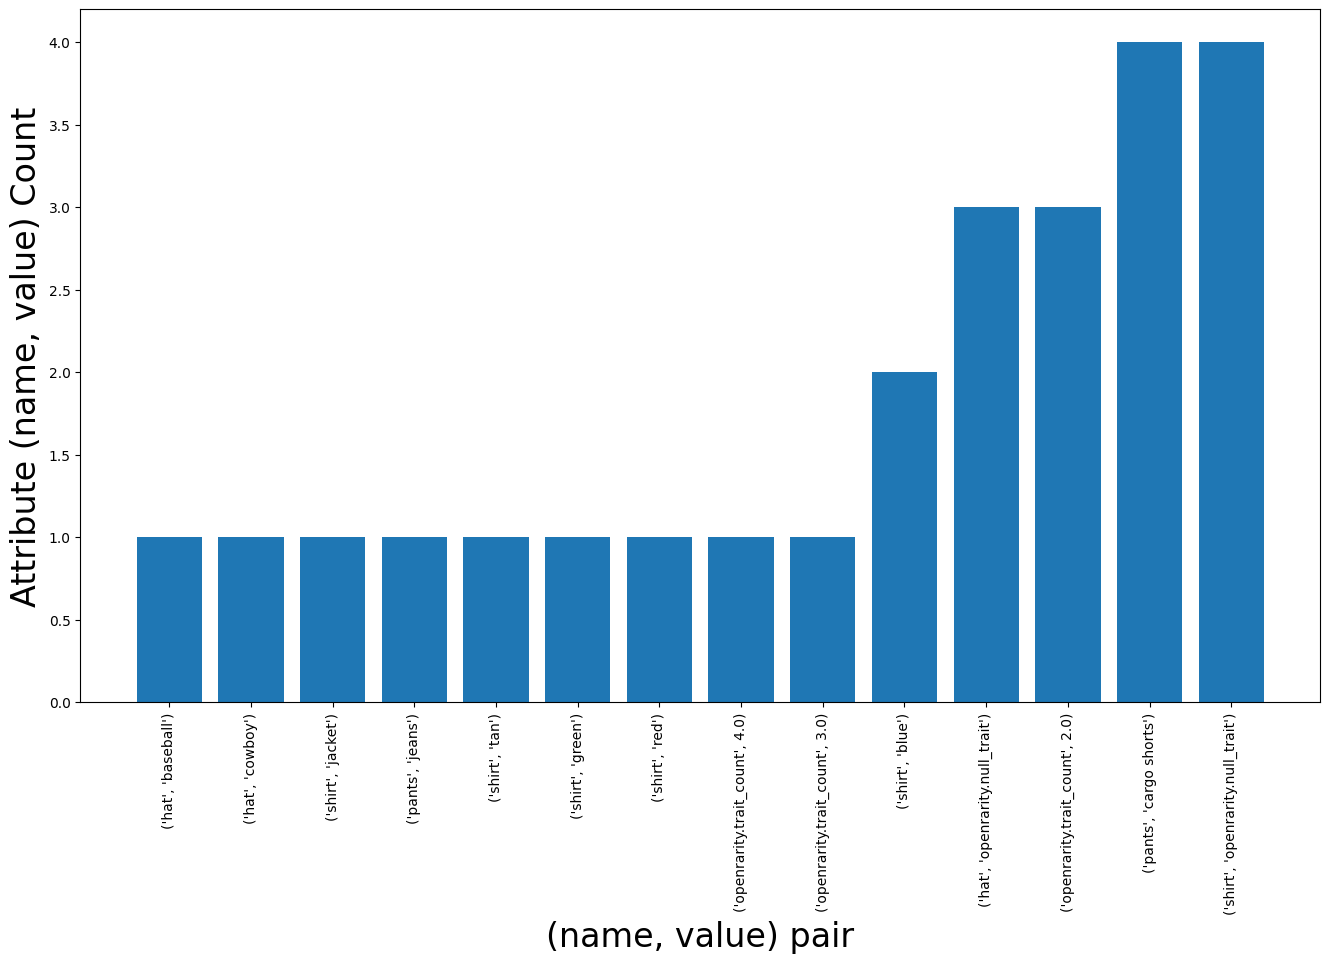

In [48]:
import matplotlib.pyplot as plt

counts = sorted(
    [
        ((attr["name"], attr["value"]), int(attr["count"]))
        for attr in token_collection.attribute_statistics
    ],
    key=lambda c: (c[1], len(c[0][0])),
)
plt.subplots(figsize=(16,9))
plt.bar([str(c[0]) for c in counts], [c[1] for c in counts])
plt.xticks(rotation=90)
plt.xlabel("(name, value) pair", size=24)
plt.ylabel("Attribute (name, value) Count", size=24)
plt.show()


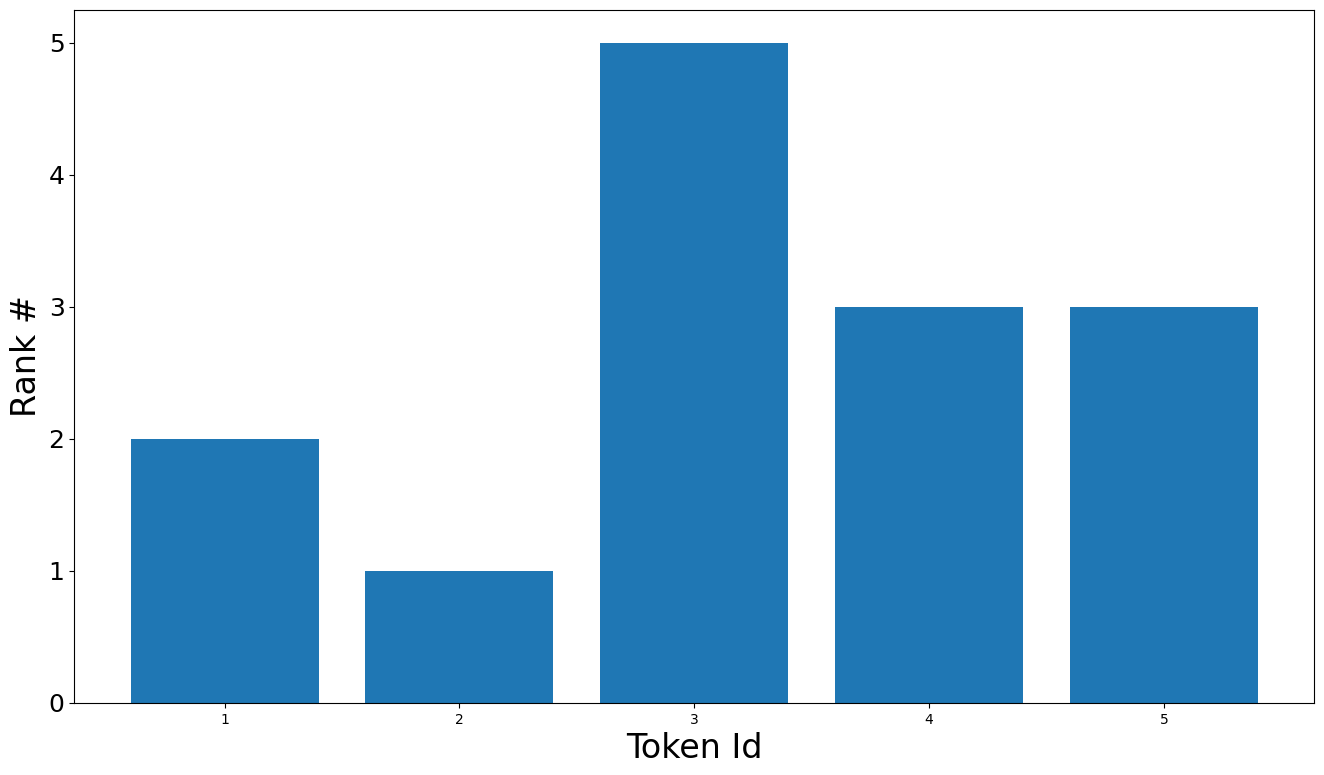

In [64]:
ranks = sorted(
    [
        (int(token["token_id"]), token["rank"])
        for token in token_collection.ranks
    ],
    key=lambda t: t[0]
)
plt.subplots(figsize=(16,9))
plt.bar([str(t[0]) for t in ranks], [r[1] for r in ranks])
plt.yticks(range(6), size=18)
plt.xlabel("Token Id", size=24)
plt.ylabel("Rank #", size=24)
plt.show()
